In [1]:
%matplotlib notebook


Bad key "text.kerning_factor" on line 4 in
C:\Users\Agata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt

In [3]:
from wczytywanie_i_blinki_mne_numpy import wczytaj, detektor_bs

In [4]:
path = 'sub-ARZ000_task_art_watch1_run-01.vhdr'
signal_from_mne = wczytaj(path)
ica = detektor_bs(signal_from_mne, "mne_lib")

Extracting parameters from sub-ARZ000_task_art_watch1_run-01.vhdr...
Setting channel info structure...
Reading 0 ... 298719  =      0.000 ...   298.719 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=16)]: Done   8 out of  19 | elapsed:    8.0s remaining:   11.0s
[Parallel(n_jobs=16)]: Done  12 out of  19 | elapsed:    8.5s remaining:    4.9s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 271 samples (0.271 sec)



[Parallel(n_jobs=16)]: Done  16 out of  19 | elapsed:    9.7s remaining:    1.7s
[Parallel(n_jobs=16)]: Done  19 out of  19 | elapsed:    9.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.0s


Analiza z wykorzystaniem biblioteki mne
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=16)]: Done   8 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  19 out of  19 | elapsed:    0.1s finished
C:\Users\Agata\anaconda3\lib\site-packages\mne\utils\check.py:90: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\Agata\anaconda3\lib\site-packages\mne\utils\check.py:90: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
F:\Studia\Zespołowy_projekt_studencki\repo\gamma-oscilation-during-saccades\wczytywanie_i_blinki_mne_numpy.py:177: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `info

Selecting by number: 19 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components


In [6]:
Fs = signal_from_mne.info['sfreq']
t_vec = signal_from_mne.times

In [7]:
df = signal_from_mne.annotations.to_data_frame()
print(df)
# print(df.loc[df.description.str.contains("/M")])

                        onset  duration              description
0  2021-12-17 18:16:42.712058     0.001             New Segment/
1  2021-12-17 18:16:42.752058     0.001  Comment/actiCAP Data On
2  2021-12-17 18:16:44.890058     0.001            Response/I 01
3  2021-12-17 18:16:55.031058     0.001            Response/M 33
4  2021-12-17 18:16:57.082058     0.001         Response/T 01 32
..                        ...       ...                      ...
72 2021-12-17 18:21:15.264058     0.001           Response/P 211
73 2021-12-17 18:21:22.370058     0.001            Response/M 33
74 2021-12-17 18:21:24.405058     0.001            Response/T 02
75 2021-12-17 18:21:26.440058     0.001           Response/P 212
76 2021-12-17 18:21:33.479058     0.001            Response/E 00

[77 rows x 3 columns]


In [8]:
def get_min_diff(sig, idx_to_diff):
    #idx_to_diff = 0.2*Fs
    diff_sig = np.abs(sig[:-idx_to_diff] - sig[idx_to_diff:])
    return np.quantile(diff_sig, 0.67)

def get_max_diff(sig, idx_to_diff):
    diff_sig = np.abs(sig[:-idx_to_diff] - sig[idx_to_diff:])
    return np.quantile(diff_sig, 0.955)

def moving_average(signal, len_single_avrg, overlap=1, extend=True):
    '''
    signal - zapis sygnału
    len_single_avrg - długość w liczbie próbek z jakiego okresu liczona jest średnia
    overlap - liczba nakładający się próbek sygnału
    Funkcja zwraca wektor średnich dla len_single_avrg liczby próbek wstecz

    '''
    sig_len = len(signal)
    samples_to_avrg = int(len_single_avrg - overlap)
    mov_avrgs_len = int(round(sig_len / samples_to_avrg))

    mov_avrgs = np.zeros(sig_len)
    mov_avrgs[:len_single_avrg] = np.mean(signal[:len_single_avrg])

    
    for i in range(samples_to_avrg, sig_len - len_single_avrg, samples_to_avrg):
        mov_avrgs[i: i + len_single_avrg] = np.mean(signal[i: i + len_single_avrg])
        

    for i in range(len_single_avrg, 0, -1):
        mov_avrgs[-i:i] = np.mean(signal[-i:])



    return mov_avrgs


def find_saccades(sig, mov_avrg, Fs, min_diff = 25, max_diff = 80):
    '''
    signal - zapis sygnału
    sig_mov_avrgs - wektor średnich rozszerzonych na długość całego sygnału

    Funkcja zwraca potencjalne początki i końce sakkad w postaci indeksów próbek sygnału
    '''
    step = int(0.02*Fs) # bo minimalna długość sakkady

    avg_len = int(0.4*Fs)
    mov_avg =  moving_average(sig, avg_len)
    mov_avg_diff = sig - mov_avg
    beg_idx = np.where(np.abs(mov_avg_diff) > min_diff)[0]
    
    new_ma = moving_average(sig, step, 5)
    new_ma_diff = np.diff(new_ma)
    
    diff = np.diff(sig)
    
    sacc_idx = []
    new_idx = []
    final_saccades = []
    for i in range(sig.shape[0]//avg_len):
        sacc = np.intersect1d(beg_idx[beg_idx>i*avg_len], beg_idx[beg_idx<(i+1)*avg_len])
        ma_diff = mov_avg[sacc] - sig[sacc]
        
        if np.any(ma_diff < 0) and np.any(ma_diff > 0):
            new_point = int(np.median(sacc))
            # w otoczeniu 0.2 s znajdź, gdzie pochodna jest nawiększa i wybierz ten punkt
            
            t_range = int(0.1 * Fs)

            if new_point - t_range < 0:
                new_point = np.argmax(diff[:new_point+t_range])
            
            elif new_point >= len(diff) - t_range:
                new_point = np.argmax(diff[new_point-t_range:]) + new_point-t_range
                
            else:
                new_point = np.argmax(diff[new_point-t_range:new_point+t_range]) + new_point-t_range
            
            znak = new_ma[new_point]/np.abs(new_ma[new_point])

            sacc_snake = new_ma_diff * znak >= 0

            s_i = 1
            while True or new_point+s_i < sacc_snake.shape[0]:
                if sacc_snake[new_point+s_i]:
                    final_saccades.append(new_point+s_i)

                else:
                    break
                s_i += 1

            s_i = 0
            while True:
                if sacc_snake[new_point+s_i]:
                    final_saccades.append(new_point+s_i)
                else:
                    break
                s_i -= 1


            new_idx.append(new_point)

        if np.abs(mov_avg[i*avg_len] - mov_avg[i*avg_len - step]) > max_diff:
            new_point = int(i*avg_len - step)
            
            znak = new_ma[new_point]/np.abs(new_ma[new_point])

            sacc_snake = new_ma_diff * znak >= 0

            s_i = 1
            while True:
                if sacc_snake[new_point+s_i]:
                    final_saccades.append(new_point+s_i)

                else:
                    break
                s_i += 1

            s_i = 0
            while True or new_point-s_i > 0:
                if sacc_snake[new_point+s_i]:
                    final_saccades.append(new_point+s_i)
                else:
                    break
                s_i -= 1


            new_idx.append(new_point)
        
    
    final_saccades.sort()
    final_saccades = np.array(final_saccades)
    mask = (np.diff(final_saccades) == 1).astype(np.uint8) * Fs

    return new_ma, final_saccades




In [26]:
class Epoch:
    def __init__(self, event_prop):
        self._idx = event_prop["event_idx"]
        self._onset = event_prop["onset"]
        self._duration = event_prop["duration"]
        self._series = event_prop["series"]
        self._img_no = event_prop["image_number"]
        self._st_idx = None
        self._end_idx = None
        self._sig = None
        self._t = None
        self._saccades_idx = None
        
    def __str__(self):
        return self._series + self._img_no
    
    def __repr__(self):
        return self._series + self._img_no
        
    def get_epoch_signal(self, sig_mne):
        #TODO Czy tu dajemy zrekonstruowany sygnał czy oryginalny
        Fs = sig_mne.info['sfreq']
        self._st_idx = sig_mne.time_as_index(self._onset)[0]
        self._end_idx = self._st_idx + int(self._duration*Fs)
        self._sig = sig_mne[:,self._st_idx:self._end_idx][0]
        self._t = sig_mne.times[self._st_idx:self._end_idx]
    
    @property
    def signal(self):
        return self._sig

    def plot(self):
        n = self._sig.shape[0]
        fig, axs = plt.subplots(4, 5, figsize=(20,25))
        for i in range(n):
            axs[i//5, i%5].plot(self._t, self._sig[i,:])
        #uładnić
        #plt.savefig()
        plt.show()
        
    def find_saccades(self, ica):
        sacc_sig = ica[1, self._st_idx:self._end_idx][0][0]
        
        len_single_avrg = int(.3*Fs)
        overlap = int(.02*Fs)
        idx_to_diff = int(0.2 * Fs)
        saccades = []
        sigFp = sacc_sig

        mov_avrg = moving_average(sigFp, len_single_avrg , overlap)
        min_dff = get_min_diff(sigFp, idx_to_diff)
        max_dff = get_max_diff(sigFp, idx_to_diff)
        ma, self._saccades_idx = find_saccades(sigFp, mov_avrg, Fs, min_dff, max_dff)
        
        fig, ax = plt.subplots(figsize=(8,4))
        
        ax.plot(self._t, sacc_sig)
#         ax.plot(self._t, ma)
        ax.plot(self._t[self._saccades_idx], sacc_sig[self._saccades_idx], 'o')
        ax.set_title(self._series + self._img_no)
        plt.show()
        return sacc_sig, self._saccades_idx

class ExtractEventInfo:
    def __init__(self, start_time, end_time):
        self._start_t = start_time
        self._end_t = end_time
        self._previous_event_t = end_time
        
    def __call__(self, index, row):
        t = row.onset - self._start_t
        duration = self._previous_event_t - row.onset
        self._previous_event_t = row.onset
        img_descrp = row.description.partition("/P ")[-1]
        img_series, img_no = [img_descrp[0], img_descrp[1:]]
        props = self._to_dict(index,
                              t.total_seconds(), duration.total_seconds(), 
                              img_series, img_no)
        return props
    
    def _to_dict(self, *args):
        _DICT_PROPS = ["event_idx", "onset", "duration", "series", "image_number"]
        props_dict = {}
        for key, value in zip(_DICT_PROPS, args):
            props_dict[key] = value
        return props_dict
        

def epochs_factory(df, sig_from_mne):
    
    start_time = df.onset[0]
    end_time = df.onset.iloc[-1]
    epoch_list = []
    extractor = ExtractEventInfo(start_time, end_time)
    img_events = df.loc[df.description.str.contains("/P")]
    for idx, row in img_events.reindex().sort_index(ascending=False).iterrows():
        e = Epoch(extractor(idx, row))
        e.get_epoch_signal(sig_from_mne)
#         e.find_saccades(ica)
#         e.plot()
        epoch_list.append(e)
         #TODO
        
        
        
    return epoch_list
 
    
    


In [27]:
epoch_list = epochs_factory(df, signal_from_mne)

<IPython.core.display.Javascript object>


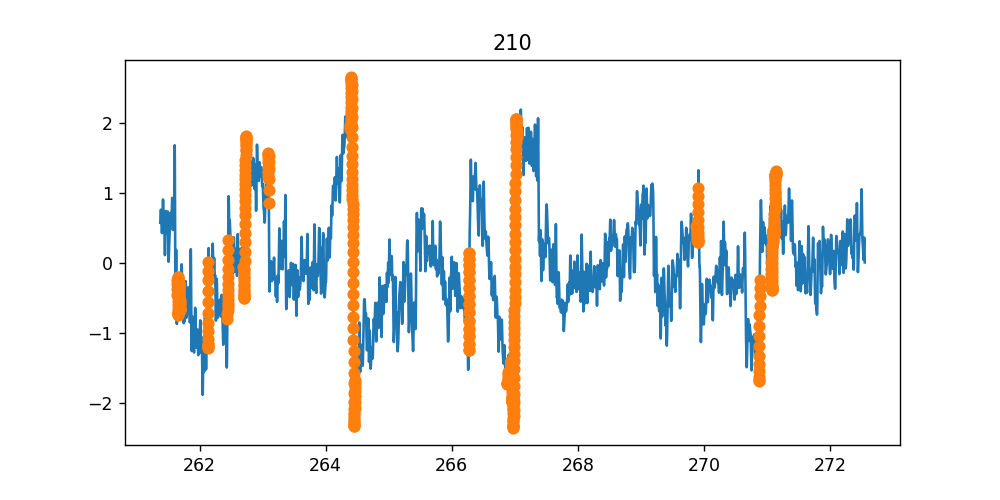

[0 0 0 ... 0 0 0]
(11175, 2)


In [159]:
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(init="random",
n_clusters=2,
 n_init=10,
max_iter=300,
random_state=42)

<IPython.core.display.Javascript object>


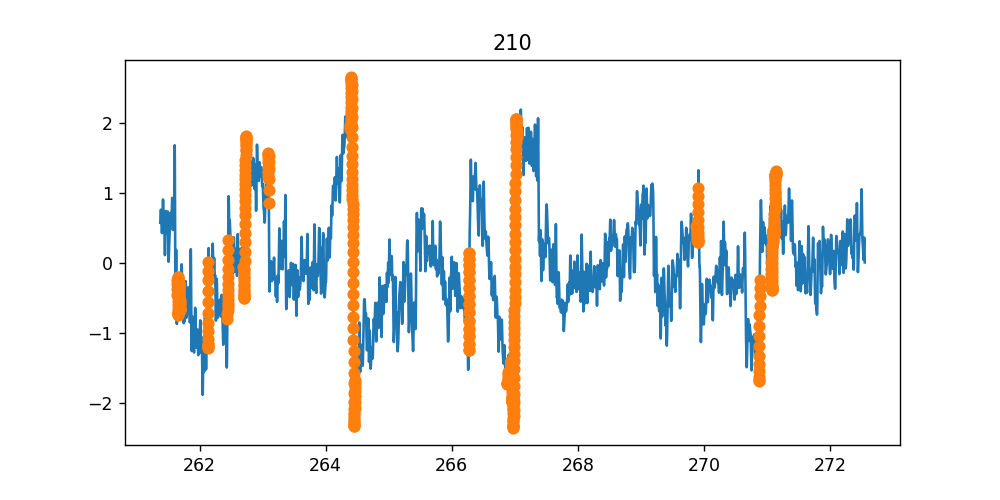

[0 0 0 ... 0 0 0]
(11174, 2)


In [160]:
e = epoch_list[2]
s = e.signal
s_ica, ssaa = e.find_saccades(ica)
sxd = np.zeros(s.shape[1], int)
sxd[ssaa] = 1
sxd[5000:6000] = 2
print(sxd)
feat = np.vstack([np.diff(s_ica), s_ica[:-1]])
feat = feat.T
print(feat.shape)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feat)
scaled_features[0,:] = scaled_features[0,:] * 30

In [161]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=2, random_state=42)

In [162]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

<IPython.core.display.Javascript object>


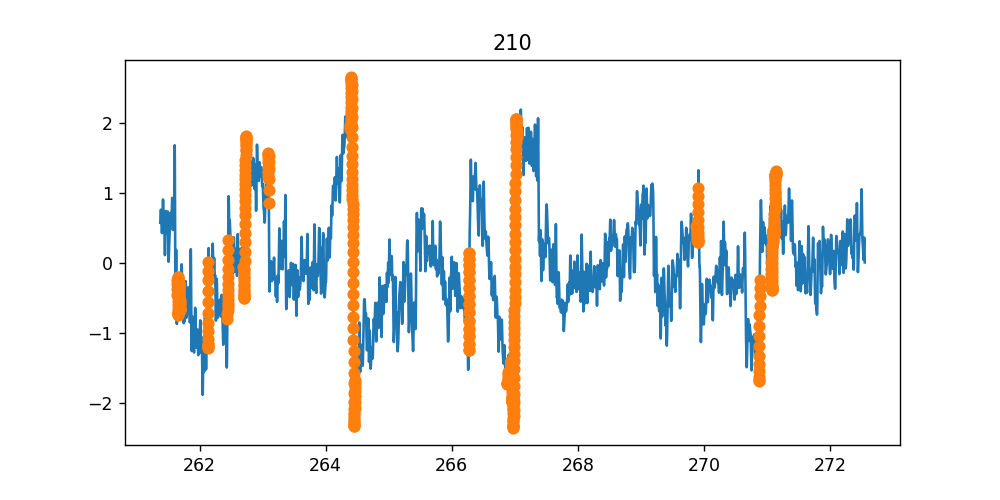

In [163]:
e = epoch_list[2]
s = e.signal
s_ica, ssaa = e.find_saccades(ica)
feat = np.vstack([np.diff(s_ica), s_ica[:-1]])
feat = feat.T
scaled_features = scaler.fit_transform(feat)
scaled_features[0,:] = scaled_features[0,:] * 30
a = kmeans.predict(scaled_features)

<IPython.core.display.Javascript object>


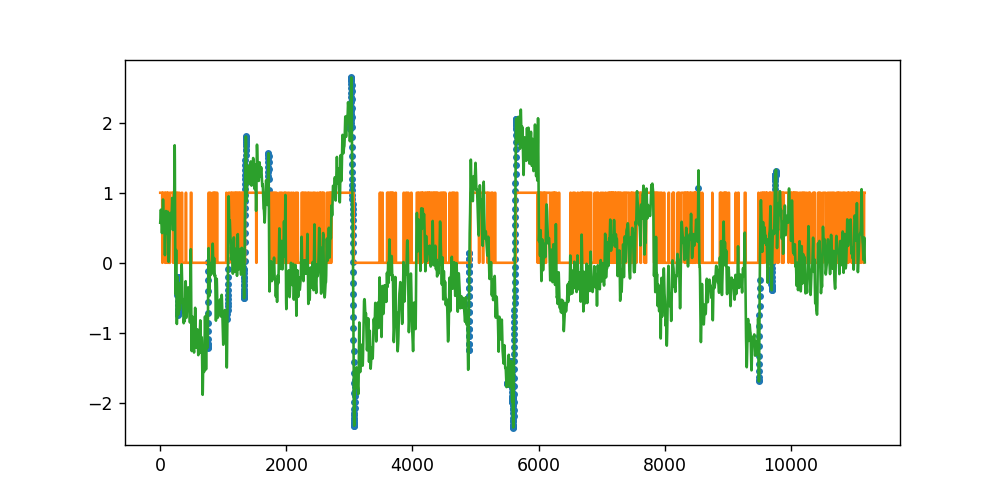

<function matplotlib.pyplot.show(*args, **kw)>

In [164]:
a

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.arange(s_ica.shape[0])[ssaa], s_ica[ssaa], '.')

ax.plot(a)
ax.plot(s_ica)
plt.show

In [153]:
sxd.shape

(11175,)

In [140]:
np.where(a==1)

(array([], dtype=int64),)

array([0, 0, 0, ..., 2, 2, 2])

(array([  511,   512,   513,   514,   515,   516,   517,   518,   519,
          520,   521,   522,   523,   524,   525,   526,   527,   528,
          529,   530,   531,   532,   533,   534,   535,   536,   537,
          538,   539,   540,   541,   542,   543,   544,   545,   546,
          547,   548,   549,   550,   551,   552,   553,   554,   555,
          556,   557,   558,   559,   560,   561,   562,   563,   564,
         2592,  2593,  2594,  2595,  2596,  2597,  2598,  2599,  2600,
         2601,  2602,  2603,  2604,  2605,  2606,  2607,  2608,  2609,
         2610,  2611,  2612,  2613,  2614,  2615,  2616,  2617,  2618,
         2619,  2620,  2621,  2622,  2623,  2624,  2625,  2626,  2627,
         2628,  2629,  2630,  2631,  2632,  2633,  2634,  2635,  2636,
         2637,  2638,  3310,  3311,  3312,  3313,  3314,  3315,  3316,
         3317,  3318,  3319,  3320,  3321,  3322,  3323,  3324,  3325,
         3326,  3327,  3328,  3329,  3330,  3331,  3332,  3333,  3334,
      